In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa.shape

(144, 1)

In [9]:
# Defining the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    
print(bb.shape)

(144, 1)


In [10]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [11]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [12]:
baseline_coord = data.iloc[:,:].values

In [13]:
standard_coord = baseline_coord.reshape((1, -1))

In [14]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [15]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = np.ones((5,1)) - 0.02*h[i]
    xRight = np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-1, yLeft))
        RightImp = np.hstack((xRight-1, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [16]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [17]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [18]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [19]:
x = np.hstack((aa, hh, bb, total_coords))

In [20]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [21]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [22]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [23]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [24]:
y.shape

(144, 2)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [26]:
x_train.shape

(129, 113)

In [27]:
y_train.shape

(129, 2)

In [28]:
tf.keras.backend.set_image_data_format('channels_last')

In [29]:
n_units

128

In [30]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# CNN autoencoder
model = tf.keras.Model(input_data, output_data)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 2)                 34    

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [34]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [35]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
6/6 [==============================] - 1s 5ms/step - loss: 1.3359 - rmse: 1.1558 - lr: 0.0010
Epoch 2/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.2182 - rmse: 0.4671 - lr: 0.0010
Epoch 3/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.1556 - rmse: 0.3944 - lr: 0.0010
Epoch 4/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.1378 - rmse: 0.3712 - lr: 0.0010
Epoch 5/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0882 - rmse: 0.2969 - lr: 0.0010
Epoch 6/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0745 - rmse: 0.2729 - lr: 0.0010
Epoch 7/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0745 - rmse: 0.2729 - lr: 0.0010
Epoch 8/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0511 - rmse: 0.2262 - lr: 0.0010
Epoch 9/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0609 - rmse: 0.2468 - lr: 0.0010
Epoch 10/5000
6/6 [==================

Epoch 77/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0282 - rmse: 0.1679 - lr: 0.0010
Epoch 78/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0235 - rmse: 0.1532 - lr: 0.0010
Epoch 79/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0220 - rmse: 0.1482 - lr: 0.0010
Epoch 80/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0197 - rmse: 0.1404 - lr: 0.0010
Epoch 81/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0196 - rmse: 0.1400 - lr: 0.0010
Epoch 82/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0176 - rmse: 0.1325 - lr: 0.0010
Epoch 83/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0205 - rmse: 0.1433 - lr: 0.0010
Epoch 84/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0187 - rmse: 0.1368 - lr: 0.0010
Epoch 85/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0267 - rmse: 0.1635 - lr: 0.0010
Epoch 86/5000
6/6 [=========

6/6 [==============================] - 0s 4ms/step - loss: 0.0212 - rmse: 0.1456 - lr: 0.0010
Epoch 153/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0252 - rmse: 0.1587 - lr: 0.0010
Epoch 154/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0225 - rmse: 0.1500 - lr: 0.0010
Epoch 155/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0253 - rmse: 0.1590 - lr: 0.0010
Epoch 156/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0345 - rmse: 0.1857 - lr: 0.0010
Epoch 157/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0366 - rmse: 0.1913 - lr: 0.0010
Epoch 158/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0252 - rmse: 0.1589 - lr: 0.0010
Epoch 159/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0195 - rmse: 0.1398 - lr: 0.0010
Epoch 160/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.0208 - rmse: 0.1441 - lr: 0.0010
Epoch 161/5000
6/6 [==============

6/6 [==============================] - 0s 5ms/step - loss: 0.0176 - rmse: 0.1328 - lr: 0.0010
Epoch 228/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0213 - rmse: 0.1459 - lr: 0.0010
Epoch 229/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0154 - rmse: 0.1240 - lr: 0.0010
Epoch 230/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0215 - rmse: 0.1467 - lr: 0.0010
Epoch 231/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0138 - rmse: 0.1173 - lr: 0.0010
Epoch 232/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0176 - rmse: 0.1328 - lr: 0.0010
Epoch 233/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1237 - lr: 0.0010
Epoch 234/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0173 - rmse: 0.1317 - lr: 0.0010
Epoch 235/5000
1/6 [====>.........................] - ETA: 0s - loss: 0.0123 - rmse: 0.1110
Epoch 235: ReduceLROnPlateau reducing learning rate

6/6 [==============================] - 0s 5ms/step - loss: 0.0201 - rmse: 0.1416 - lr: 5.0000e-04
Epoch 299/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0164 - rmse: 0.1280 - lr: 5.0000e-04
Epoch 300/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0160 - rmse: 0.1263 - lr: 5.0000e-04
Epoch 301/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0143 - rmse: 0.1197 - lr: 5.0000e-04
Epoch 302/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0160 - rmse: 0.1263 - lr: 5.0000e-04
Epoch 303/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0161 - rmse: 0.1270 - lr: 5.0000e-04
Epoch 304/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0164 - rmse: 0.1279 - lr: 5.0000e-04
Epoch 305/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0175 - rmse: 0.1322 - lr: 5.0000e-04
Epoch 306/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0162 - rmse: 0.1274 - lr: 5.0000e-0

6/6 [==============================] - 0s 6ms/step - loss: 0.0144 - rmse: 0.1201 - lr: 5.0000e-04
Epoch 371/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0192 - rmse: 0.1384 - lr: 5.0000e-04
Epoch 372/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0169 - rmse: 0.1299 - lr: 5.0000e-04
Epoch 373/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0148 - rmse: 0.1215 - lr: 5.0000e-04
Epoch 374/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0153 - rmse: 0.1235 - lr: 5.0000e-04
Epoch 375/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0146 - rmse: 0.1210 - lr: 5.0000e-04
Epoch 376/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0162 - rmse: 0.1272 - lr: 5.0000e-04
Epoch 377/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0146 - rmse: 0.1209 - lr: 5.0000e-04
Epoch 378/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0172 - rmse: 0.1310 - lr: 5.0000e-0

6/6 [==============================] - 0s 6ms/step - loss: 0.0132 - rmse: 0.1149 - lr: 5.0000e-04
Epoch 443/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0154 - rmse: 0.1240 - lr: 5.0000e-04
Epoch 444/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0136 - rmse: 0.1166 - lr: 5.0000e-04
Epoch 445/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0155 - rmse: 0.1244 - lr: 5.0000e-04
Epoch 446/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0133 - rmse: 0.1152 - lr: 5.0000e-04
Epoch 447/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0141 - rmse: 0.1188 - lr: 5.0000e-04
Epoch 448/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0133 - rmse: 0.1154 - lr: 5.0000e-04
Epoch 449/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0134 - rmse: 0.1160 - lr: 5.0000e-04
Epoch 450/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0152 - rmse: 0.1234 - lr: 5.0000e-0

6/6 [==============================] - 0s 6ms/step - loss: 0.0142 - rmse: 0.1190 - lr: 2.5000e-04
Epoch 514/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0121 - rmse: 0.1101 - lr: 2.5000e-04
Epoch 515/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0108 - rmse: 0.1039 - lr: 2.5000e-04
Epoch 516/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0142 - rmse: 0.1193 - lr: 2.5000e-04
Epoch 517/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0122 - rmse: 0.1106 - lr: 2.5000e-04
Epoch 518/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0117 - rmse: 0.1083 - lr: 2.5000e-04
Epoch 519/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0125 - rmse: 0.1116 - lr: 2.5000e-04
Epoch 520/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0135 - rmse: 0.1162 - lr: 2.5000e-04
Epoch 521/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0133 - rmse: 0.1153 - lr: 2.5000e-0

6/6 [==============================] - 0s 6ms/step - loss: 0.0114 - rmse: 0.1070 - lr: 2.5000e-04
Epoch 586/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0111 - rmse: 0.1052 - lr: 2.5000e-04
Epoch 587/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0116 - rmse: 0.1079 - lr: 2.5000e-04
Epoch 588/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0142 - rmse: 0.1193 - lr: 2.5000e-04
Epoch 589/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0122 - rmse: 0.1104 - lr: 2.5000e-04
Epoch 590/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0130 - rmse: 0.1140 - lr: 2.5000e-04
Epoch 591/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0115 - rmse: 0.1074 - lr: 2.5000e-04
Epoch 592/5000
1/6 [====>.........................] - ETA: 0s - loss: 0.0104 - rmse: 0.1018
Epoch 592: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
6/6 [==============================] - 0s 6ms/step - l

In [36]:
time = end - start
print("Training time:", time)

Training time: 0:00:21.781881


In [37]:
os.chdir("D:\\VAWT_data\\flap_steady\\flap_steady\\result\\MLP")

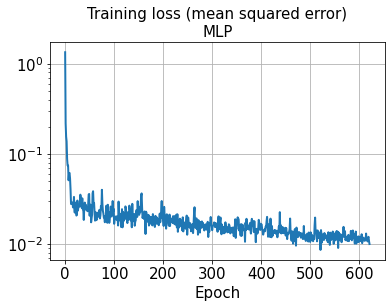

In [38]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

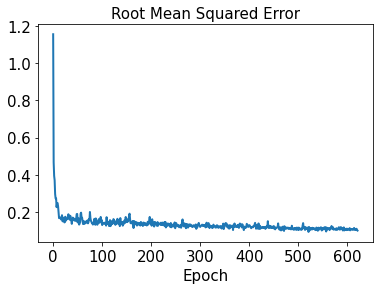

In [39]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

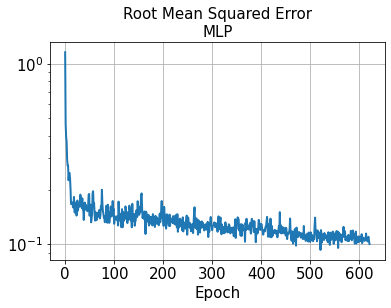

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [41]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 123ms/step - loss: 0.0103 - rmse: 0.1013


In [42]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 14ms/step


In [43]:
model_directory = "D:\\TrainedModels\\20221112"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221112steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
error_train_abs = np.abs(decoded_train - y_train)

In [45]:
error_test_abs = np.abs(decoded_test - y_test)

In [46]:
os.chdir("D:\\VAWT_data\\flap_steady\\flap_steady\\result\\MLP")

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.12706055880998365


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.11709798003890157


In [49]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[0] - y_train[0])**2) / np.sum(y_train[0]**2))
print(l2_error_Cd_train)

0.20198091125689308


In [50]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[1] - y_train[1])**2) / np.sum(y_train[1]**2))
print(l2_error_Cl_train)

0.010167914434767191


In [51]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[0] - y_test[0])**2) / np.sum(y_test[0]**2))
print(l2_error_Cd_test)

0.14641754498629567


In [52]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[1] - y_test[1])**2) / np.sum(y_test[1]**2))
print(l2_error_Cl_test)

0.2732663614115825


In [53]:
os.getcwd()

'D:\\VAWT_data\\flap_steady\\flap_steady\\result\\MLP'

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [56]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [57]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [58]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [59]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

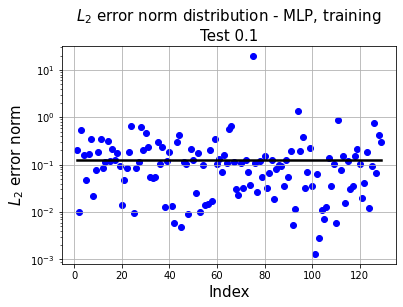

In [60]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

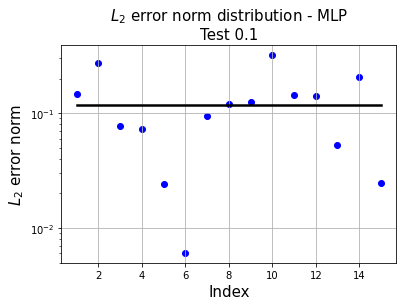

In [61]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP\nTest {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

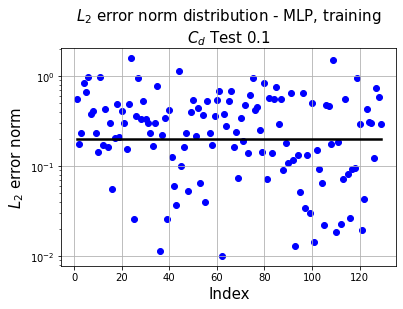

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

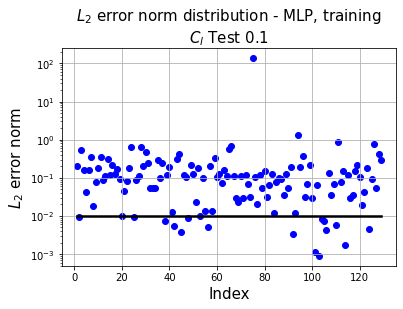

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

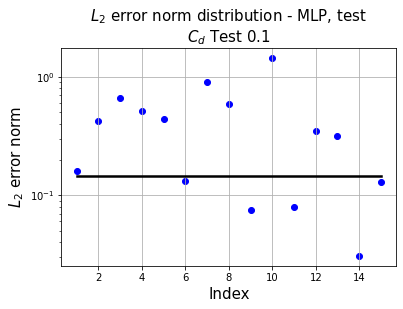

In [64]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

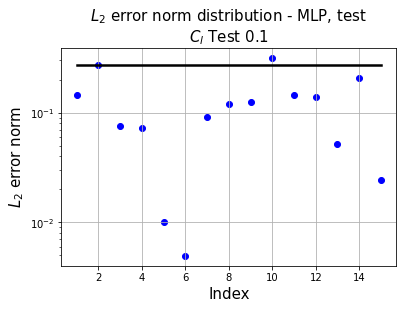

In [65]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()